# Figure 2 - A 2D projection of the LSA clustering performance

## Rationale

We claim that the transformation of the corpus to a high-dimensional n-gram space preserves stylistic differences. This claim must be supported before using any kind of distance measure to detect stylistic outliers like the Additamentum. In addition, we demonstrate that in the case of Latin poetry "small" chunks (81 lines) are still large enough for reliable stylistic analysis with LSA.

## Method

We transform the corpus twice. First, to normalise phonetic representation and for Named Entity Normalisation. Next, we chunk the data and lift each chunk into the feature space, which uses 2-, 3- and 4-gram frequencies, scaled by TF-IDF. From the full dimensionality representation (~36k features), we project down directly to 2 dimensions using UMAP ([paper](https://arxiv.org/abs/1802.03426), [project](https://github.com/lmcinnes/umap))

## Limitations

UMAP is a manifold projection algorithm. It tries to preserve a "fuzzy topology" which is to say that it attempts to retain as much of the _local_ neighbourhood structure as it can. Points that are close to each other in the projected space should be stylistically similar. However, points that are 'far' are not neccessarily as dissimilar as they seem. The euclidean metric (ie the simple distance) between points in the projection is not a reliable measure of their _dissimilarity_. In particular, the fact that the Additamentum is 'very far' from the rest of Silius IN THIS FIGURE is indicative but not directly probative. It _is_ however reasonable to say that the Additamentum is stylistically closer to the Aeneid (its nearest neighbours) than to the rest of the Punica.

## What This Figure Shows

The main point that is demonstrated here is that the clusters are well separated. The chunks that make up each work cluster well together, and the works of each author (for eg Ovid and Vergil that are represented by several different works) cluster together more broadly. This figure shows that LSA is an effective way to differentiate authorial style for Latin poetry. Not only that, it is also effective _at this chunk size_.


In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import math
import string
import pickle

from sklearn.utils.extmath import density

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import pairwise_distances

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.svm import SVC, LinearSVC

from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB, BernoulliNB

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.linear_model import SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

In [2]:
import umap

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# my own code, here: https://github.com/bnagy/mqdq-parser

from mqdq import ngrams
# despite the confusing parameter name, drop_addit still includes it in the
# corpus, it's just broken out into one separate chunk, with the Author set
# to 'Unknown' and the Work set to 'Punica'
corpus = ngrams.geezit_corpus(chunksz=81, drop_propers=True, drop_addit=True)

## About the transformed text

Each of the works here have been transformed by preprocessing code. There are two major preprocessing steps:

### 1. Phonetic Representation

In this step, things like 'c' are transformed to /k/, 'u' to either /u/ (vowel) or /w/ consonant, 'i' to /i/ or /j/ etc. This lets us more clearly see the way the authors collocate phonemes rather than hiding that aspect behind a layer of orthography. Another part of this step is the marking of _elision_ with an underscore. This lets the elision marker form part an n-gram, so that authors who use more elision, or elision in different ways can be explicitly detected as stylistically distinct. Note that line endings are preserved, because it is reasonable to suppose that the sounds that are placed at the starts or ends of lines carry stylistic weight.

### 2. Named Entity Normalisation

In this step we attempt to remvove proper nouns. This step aims to "stop the computer from cheating". If, for example, we left in proper nouns, it would be easy to write a classifier for the Aeneid that simply looked for a higher than usual frequency of the 3-gram 'aen'. This is a kind of overfitting. To some extent, we are at the mercy of the editors, since named entities must be detected using capitalisation, but the results from the preprocessing code seem fairly good. We have chosen to convert every named entity to a single glyph '8' that does not appear elsewhere in the corpus. The transformation _preserves elision_ so that we can see how often authors elide proper nouns etc. By transforming the names into a token, rather than deleting them, we can preserve the frequency and position of proper nouns as a stylistic signal while reducing the risk of overfitting.

The code used for the preprocessing is available [here](https://github.com/bnagy/mqdq-parser). This code was written by the paper authors, and is supplied with a permissive license.

In [5]:
# A quick look at the start of the Aeneid, after transformation...

corpus.Chunk[0]

'arma wirumkwe kano 8 kwi primus ab oris\n8 fato profugus 8 wenit\nlitora mul_til_let terris jaktatus et alto\nwi superum saewae memorem 8 ob iram\nmulta kwo_kwet bello passus dum konderet urbem\ninferretkwe deos 8 genus unde 8\nalbanikwe patres at_kwaltae moenia 8\nmusa mihi kausas memora kwo numine laeso\nkwidwe dolens regina deum tot wolwere kasus\ninsinjem pietate wirum tot adire labores\nimpulerit tantae_nanimis kaelestibus irae\nurbs antikwa fuit 8 tenuere koloni\nkarta_8 kontra 8 longe\nostia diwes opum studiis_kwasperrima 8\nkwam 8 fertur terris magis omnibus unam\nposthabita koluisse 8 hik illius arma\nhik kurrus fuit hok renjum dea gentibus esse\nsi kwa fata sinant jam tum tenditkwe fowetkwe\nprogeniem sed enim 8_na sangwine duki\naudierat 8 olim kwae werteret arkes\nhink populum late regem bellokwe superbum\nwentu_rekskidio 8 sik wolwere 8\nid metuens weteriskwe memor 8 8\nprima kwod ad 8 pro karis gesserat 8\nnek_detiam kau_sirarum saewikwe dolores\nekskiderant animo manet 

# Classification Accuracy - Is it reasonable to trust LSA on such small chunks?

First we set up some utility functions.

In [6]:
def mean_confidence_interval(data, confidence=0.95):
    '''
    Calculate the 95% confidence interval around the mean for an array of numbers.
    Uses one-sample T-test.
    '''
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.stats.sem(a)
    h = se * sp.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [7]:
def classifier_test(clf, corp, svd_dims=None, do_cv=True):
    
    '''
    Given a classifier, a corpus and an SVD dimensions parameter, set up
    a scikit Pipeline object and run 10-fold cross validation with a 
    Stratified Shuffle & Split strategy.
    
    Scoring is recall weighted since penalising false negatives in a very
    multi-class problem is harsh.
    '''
    
    p=None
    rng = np.random.RandomState(seed=1234)
    print("Testing Classifier: %s" % clf)

    # We make a pipeline with the TF-IDF vectorizer because that way the
    # cross validation correctly retrains the TF-IDF on the training data
    # only at each fold.
    if svd_dims:
        print("Doing Truncated SVD at %d dimensions" % svd_dims)
        p = make_pipeline(
            TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4)),
            TruncatedSVD(svd_dims, random_state=rng),
            Normalizer(copy=False),
            clf,
        )
    else:
        print("Running at full dimensionality")
        p = make_pipeline(
            TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4)),
            clf,
        )
        
    clf_res = {'Author':[], 'Work':{}}
    if do_cv:
        print("Doing 10 fold CV with 80/20 split, recall weighted")
        s = cross_val_score(p, corp.Chunk, corp.Work, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2), n_jobs=-1, scoring='recall_weighted')
        m,h = mean_confidence_interval(s)
        clf_res['Work']=[m,h]
        print("Accuracy (Work): %.2f%% ± %.3f" % (m*100, h*100))
        s = cross_val_score(p, corp.Chunk, corp.Author, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2), n_jobs=-1, scoring='recall_weighted')
        m,h = mean_confidence_interval(s)
        clf_res['Author']=[m,h]
        print("Accuracy (Author): %.2f%% ± %.3f" % (m*100, h*100))
        

# Test the Classifiers

We will test a variety of classifiers, with the idea being that if the results are strong for all classifiers (which work in very different mathematical ways) then the data separates well in the feature space _in general_. The chosen classifiers are: 
- `NearestCentroid` draws 'balloons' in high dimensional space
- `ExtraTrees` a consensus algorithm that tries to choose features that make a good decision tree
- `KNeighbours` classic k-nearest neighbours classifies point by the points nearby
- `SVC`, `LinearSVC` support vector machines try to draw lines (actually hyperplanes) that divide the classes
- `MultinomialNB` Naïve Bayes is the standard 'quick and dirty' classifier. Count data like TF-IDF is best modelled as Multinomial not Gaussian.

All of these classifiers are chosen because they are fairly standard and not because they are the best performing (some more exotic classifiers like the `PassiveAggressiveClassifier` and some less known basic ones like `Perceptron` perform very well).

In [8]:
# For the classification tests we leave out the Additamentum since we are
# interested in trying to classify securely attributed chunks.

corpus_na = corpus.query('Author != "Unknown"')

In [9]:
# The classifiers that we will test, tuples being the Classifier object and the
# number of SVD dimensions (if doing any dimensionality reduction). Some classifiers
# don't really need any reduction, whereas some (ExtraTrees in particular) don't do
# well on huge feature spaces (the unreduced TF-IDF space has about 34k features)

clfs = [
    (NearestCentroid(metric='euclidean'), None),
    (ExtraTreesClassifier(n_estimators=1000, max_features='sqrt', criterion='gini'), 180),
    (MultinomialNB(alpha=.01), None),
    (KNeighborsClassifier(n_neighbors=10),None),
    (SVC(gamma='scale', kernel='rbf', C=128), 180),
    (LinearSVC(penalty='l2', dual=False, tol=1e-3),None)
]

# Results

Classification results by Work and by Author (some authors like Ovid and Vergil have more than one work in the test corpus). Overall the performance is excellent, which demonstrates that authorial style, as reflected by character _n_-grams, is distinctive, and can in general be differentiated with quite small samples.

In [10]:
for (c,dims) in clfs:
    classifier_test(c, corpus_na, svd_dims=dims)
    print('-'*60)
    print()

Testing Classifier: NearestCentroid(metric='euclidean', shrink_threshold=None)
Running at full dimensionality
Doing 10 fold CV with 80/20 split, recall weighted
Accuracy (Work): 97.80% ± 0.486
Accuracy (Author): 99.50% ± 0.413
------------------------------------------------------------

Testing Classifier: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=1000,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Doing Truncated SVD at 180 dimensions
Doing 10 fold CV with 80/20 split, recall weighted
Accuracy (Work): 96.54% ± 0.801
Accuracy (Author): 99.12% ± 0.528
---------------------------------------------------------

# Build the UMAP plot

In [11]:
# Load R magic for Jupyter

%load_ext rpy2.ipython

In [12]:
%%capture
%%R

# Setup R stuff...

pacman::p_load(
    tidyverse,ggsci,ggpubr,ggrepel
)

A couple of utility functions here for labelling. Not very re-useable, but gets the job done.

In [13]:
# We want to apply specific labels to the points that are at the start of Punica 8,
# the points in Punica 14 which cluster with Lucan (they share a common topic, a 
# sea-battle, that dominates the authorial differences), and the Additamentum

def apply_labels(work, bref):
    if work=='Punica':
        book,line = [int(x) for x in bref.split(':')]
        if book==8 and line < 350:
            if line==144:
                return("Addit.")
            return("%s" % bref)
        if book==14 and 300 <= line <= 462:
            return("%s" % bref)
        if book==13 and line == 628:
            return("%s" % bref)
    return ""

In [14]:
# For the 'zoomed in' figure label a few more points (in Aen. 4) but not
# the points in Book 14 that are similar to Lucan.

def apply_labels_zoom(work, bref):
    if work=='Punica':
        book,line = [int(x) for x in bref.split(':')]
        if book==8 and line < 350:
            if line==144:
                return("Addit.")
            return("%s" % bref)
    elif work=='Aeneid':
        book,line = [int(x) for x in bref.split(':')]
        if book==4 and 300 <= line <= 500:
            return("%s" % bref)

    return ""

Very standard invocation of TF-IDF. We take character n-grams, and we take _all_ 2-, 3- and 4-grams.

The n-grams were chosen by experiment. Adding 5-grams probably starts to overfit, using just 2- or 3- grams
is a little less accurate.

Stopwords etc are not removed. There is significant work to indicate that high frequency function words are an important part of an author's stylistic signal. On this see eg Evert, Proisl et al [Understanding and explaining Delta measures for authorship attribution](https://academic.oup.com/dsh/article/32/suppl_2/ii4/3865676)

In [15]:
# Vectorise the corpus with TF-IDF. We need to densify the resulting dataframe to work with UMAP.

v = TfidfVectorizer(
    sublinear_tf=True, 
    use_idf=True,
    norm='l2', 
    analyzer='char',
    ngram_range=(2,4)
)
v.fit(corpus.Chunk)
data = v.transform(corpus.Chunk).todense()

In [16]:
# Project the TF-IDF points down to 2D

# Most of this is fairly standard, but the set_op_mix_ratio parameter is a little
# unusual. This is the UMAP author's recommendation for outlier detection:
# https://umap-learn.readthedocs.io/en/latest/outliers.html

plot_df = corpus.copy()
plot_df_zoom = corpus.copy()

umapper = umap.UMAP(
    n_neighbors=15,
    min_dist=0.2,
    # preserve outliers
    set_op_mix_ratio=0.25,
    # project to 2 dimensions
    n_components=2,
    metric='euclidean',
    # UMAP figures change with every run if not seeded
    random_state=2020
)

u = umapper.fit_transform(data)
plot_df['X'], plot_df['Y'] =  u[:,0], u[:,1]
plot_df['Label'] = plot_df.apply(lambda pdf: apply_labels(pdf['Work'], pdf['Bookref']), axis=1)

plot_df_zoom['X'], plot_df_zoom['Y'] =  u[:,0], u[:,1]
plot_df_zoom['Label'] = plot_df_zoom.apply(lambda pdf: apply_labels_zoom(pdf['Work'], pdf['Bookref']), axis=1)

# Now we have an X-Y coordinate applied to every chunk, and a few points have specific labels.
# We will visualise with ggplot instead of using the UMAP tools.

plot_df

,Chunk,Author,Work,Bookref,X,Y,Label
0,arma wirumkwe kano 8 kwi primus ab oris\n8 fat...,Vergil,Aeneid,1:1,-0.278580,3.964452,
1,impulit in latus ak wenti welut agmine fakto\n...,Vergil,Aeneid,1:82,-1.806255,3.999169,
2,in kaelum skopuli kworum sub wertike late\naek...,Vergil,Aeneid,1:163,-0.103732,4.782541,
3,renja 8_ret fontem superare 8\nunde per ora no...,Vergil,Aeneid,1:244,-0.308904,3.847391,
4,sik 8 et 8 kontra sik filius orsus\nnulla tua_...,Vergil,Aeneid,1:325,-0.447264,4.421149,
...,...,...,...,...,...,...,...
788,sed jakui pigro krimen onuskwe toro\nnek potui...,Ovid,Amores3,7:4,9.109666,0.084632,
789,et kwis_kwingenuas etiamnunk suspikit artes\na...,Ovid,Amores3,8:1,9.145622,0.409612,
790,kwam juweni rupit kum ferus ingwen aper\nat sa...,Ovid,Amores3,9:16,9.409850,0.183011,
791,wiktus amore pudor sulkos arere wideres\net sa...,Ovid,Amores3,10:29,8.700346,-0.076758,


## Figures

1. The colour figure preserves the book and line references for every chunk of every author and may be more generally interesting. When emitted as a high resolution PDF it can be zoomed so that all of the labels are readable, even with the overplotting. However it is more or less impossible to find 10 contrasting colours that work well for all colourblind viewers, and the number of text labels would not print well for a paper figure.

2. The monochrome figure is much uglier, but the shapes can be distinguished by any viewers, and only the points that are most relevant to the discussion at hand are labelled. This is the paper figure.

3. A colour version of the paper figure is provided, and then a 'zoomed in' plot of the border area between Silius and Vergil.

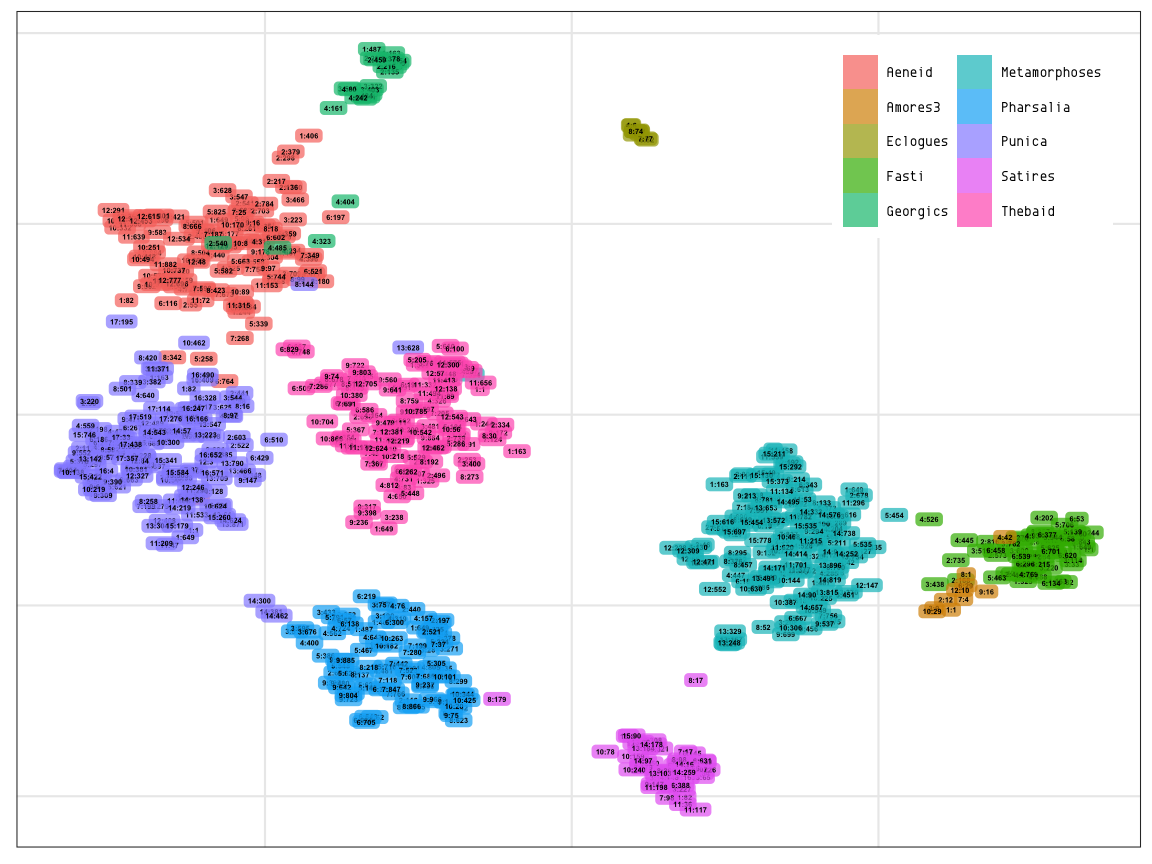

In [17]:
%%R -i plot_df -h 6 -w 8 -u in -r 144

ggplot(data=plot_df,aes(x=X, y=Y, fill=Work, label=Bookref)) +
geom_label(size=1.3, fontface='bold', label.padding = unit(0.15, "lines"), label.size=NA, alpha=0.7) +
scale_color_brewer(palette = "Paired") +
theme_bw() +
theme(plot.title = element_text(margin = margin(b = 50))) +
guides(fill = guide_legend(ncol=2,override.aes = aes(label = ""))) +
theme(legend.position = c(0.85, 0.85), legend.title=element_blank()) +
theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank())

# fn <- "poetry_umap.pdf"
# ggsave(fn, dpi=600, width=8, height=6, device=cairo_pdf)
# embed_fonts(fn)

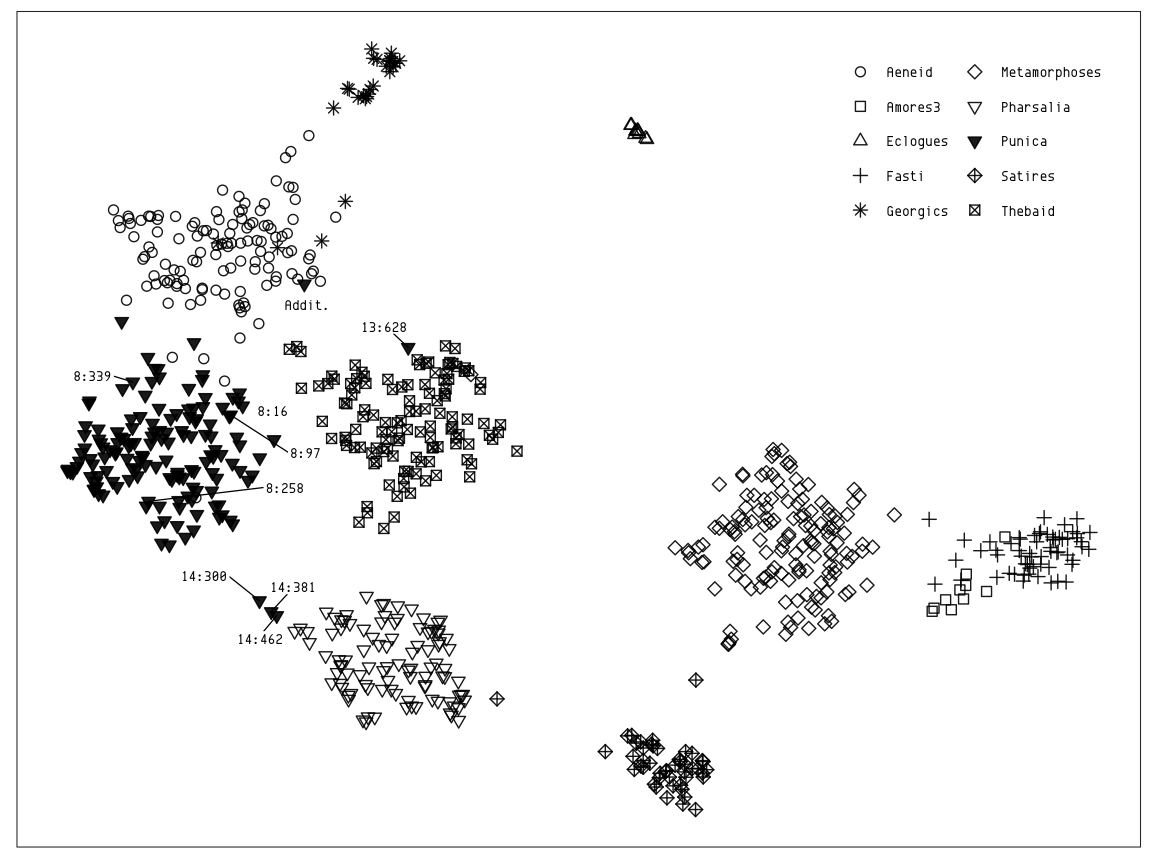

In [18]:
%%R -i plot_df -h 6 -w 8 -u in -r 144

ggplot(data=plot_df,aes(x=X, y=Y, shape=Work, label=Label)) +
geom_label_repel(
    size=2.5,
    family="Envy Code R",
    label.padding = unit(0.08, "lines"),
    label.size=NA,
    fill="white",
    max.iter=15000, # affects how nicly the text labels are placed
    force = 4.35,    # repel force for labels, not for data points
    segment.size = 0.3
) +
geom_point(alpha=0.9, size=2, fill="black") +
scale_shape_manual(values=c(1,0,2,3,8,5,6,25,9,7)) + # shapes chosen to be 'easy' to read based on the plot.
theme_bw() +
theme(plot.title = element_text(margin = margin(b = 50))) +
guides(shape = guide_legend(ncol=2,override.aes = aes(label = ""))) +
theme(legend.position = c(0.85, 0.85), legend.title=element_blank()) +
theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.major=element_blank(),panel.grid.minor=element_blank())

# fn <- "poetry_umap_bw_repro.pdf"
# ggsave(fn, dpi=600, width=8, height=6, device=cairo_pdf)
# embed_fonts(fn)

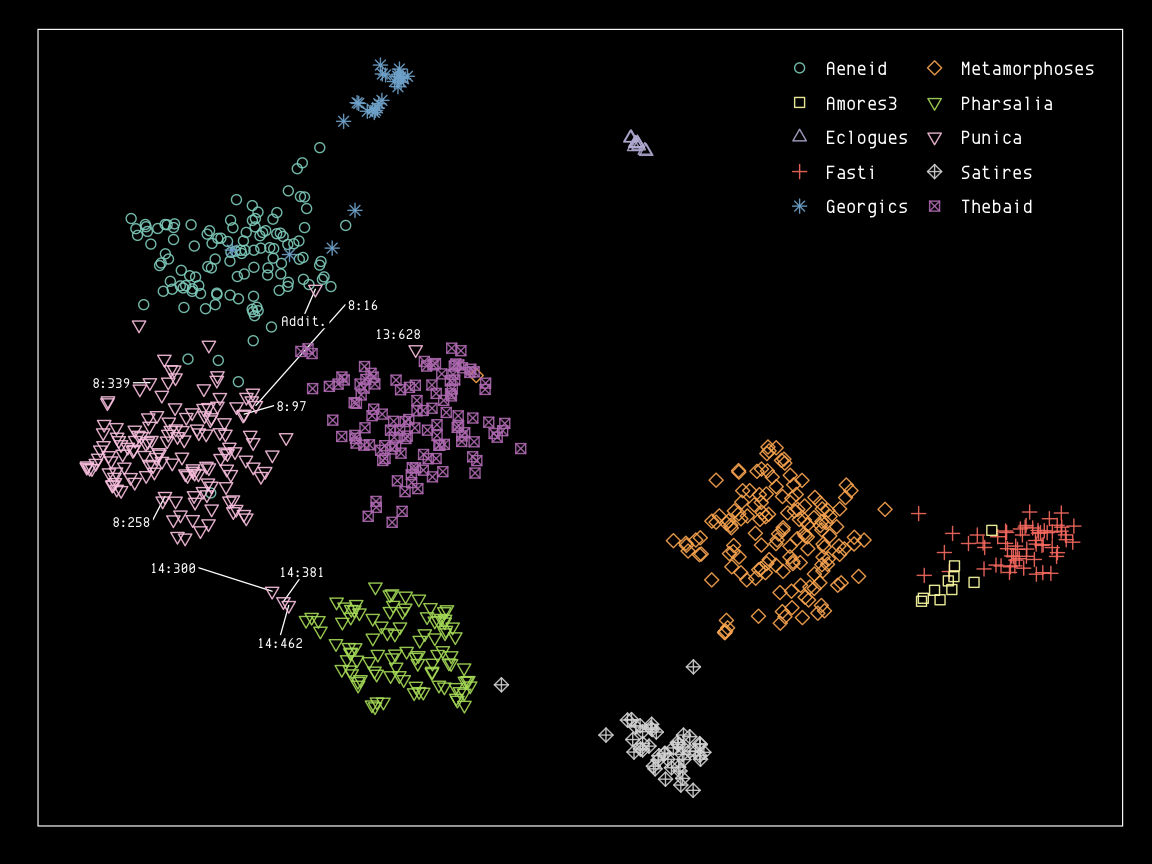

In [22]:
%%R -i plot_df -h 6 -w 8 -u in -r 144

source('/Users/ben/r/theme_black.R')

ggplot(data=plot_df,aes(x=X, y=Y, shape=Work, color=Work, label=Label)) +
geom_label_repel(
    size=2.5,
    color="white",
    family="Envy Code R",
    label.padding = unit(0.08, "lines"),
    label.size=NA,
    fill="black",
    max.iter=15000, # affects how nicly the text labels are placed
    force = 4.9,    # repel force for labels, not for data points
    segment.size = 0.3
) +
geom_point(alpha=0.9, size=2) +
scale_shape_manual(values=c(1,0,2,3,8,5,6,25,9,7)) + # shapes chosen to be 'easy' to read based on the plot.
scale_color_brewer(palette = "Set3") +
theme_black() +
theme(plot.title = element_text(margin = margin(b = 50))) +
guides(shape = guide_legend(ncol=2,override.aes = aes(label = ""))) +
theme(legend.position = c(0.83, 0.87), legend.title=element_blank()) +
theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.major=element_blank(),panel.grid.minor=element_blank())

# fn <- "poetry_umap_bw_ppt.pdf"
# ggsave(fn, dpi=300, width=8, height=6, device=cairo_pdf)
# embed_fonts(fn)

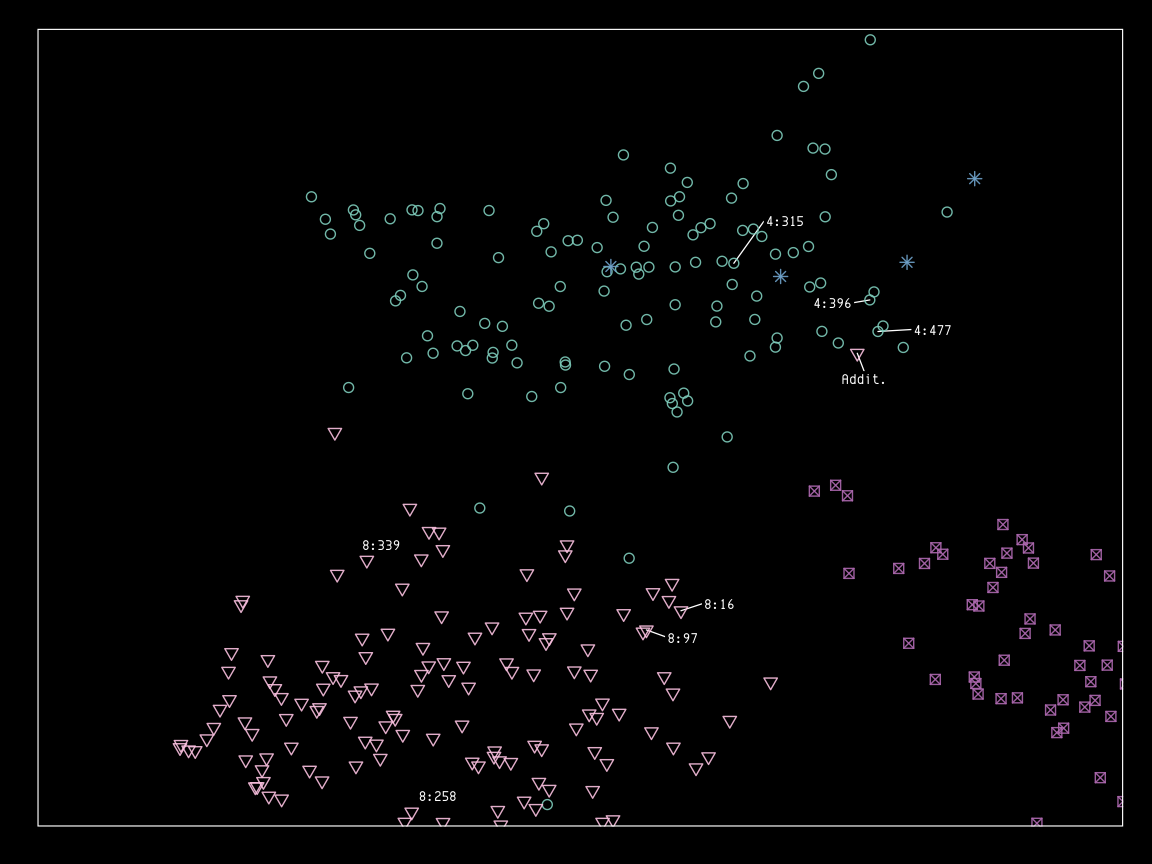

In [20]:
%%R -i plot_df_zoom -h 6 -w 8 -u in -r 144

source('/Users/ben/r/theme_black.R')

ggplot(data=plot_df_zoom,aes(x=X, y=Y, shape=Work, color=Work, label=Label)) +
geom_label_repel(
    size=2.5,
    color="white",
    family="Envy Code R",
    label.padding = unit(0.08, "lines"),
    label.size=NA,
    fill="black",
    max.iter=15000, # affects how nicly the text labels are placed
    force = 6.1,    # repel force for labels, not for data points
    segment.size = 0.3
) +
geom_point(alpha=0.9, size=2) +
scale_shape_manual(values=c(1,0,2,3,8,5,6,25,9,7)) + # shapes chosen to be 'easy' to read based on the plot.
scale_color_brewer(palette = "Set3") +
coord_cartesian(xlim = c(-3, 1.5), ylim=c(1.5,6),expand=TRUE) +
theme_black() +
theme(plot.title = element_text(margin = margin(b = 50))) +
guides(shape = guide_legend(ncol=2,override.aes = aes(label = ""))) +
theme(legend.position = 'none', legend.title=element_blank()) +
theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.major=element_blank(),panel.grid.minor=element_blank())

# fn <- "umap_zoomed_ppt.pdf"
# ggsave(fn, dpi=300, width=8, height=6, device=cairo_pdf)
# embed_fonts(fn)

In [21]:
%%capture
%%R

# Sometimes R forgets my fonts. This fixes that, but it doesn't need
# to be run every time.

pacman::p_load("extrafontdb", extrafont)
font_import(prompt=FALSE)
loadfonts()